# Kolmogorov-Smirnov test
This Jupyter notebook file allows you to perform the Kolmogorov-Smirnov (KS) test.
However, the binwidth of the data and model must match. The binwidths should satisfy the following equation: 
 $\text{binwidth}=\frac{\text{Data}_\text{max}-\text{Data}_\text{min}}{\text{number of bins}}$ 
There are two classes in the code. Below are the relevant parameters for each:  
## For the Model_plot class :
Refer to the Model PDFs and CDFs Jupyter notebook file in the GitHub repository.  
## For the KStest class : 
Parameters :
* data : the data which you want to compare
* x_max : the maximum mass that you want to draw the cdfs. It should be bigger than m_max
* m_min : the minimum cutoff of the model
* m_max : the maximum cutoff of the model
* data_binwidth : data binwidth. it should be same with model binwidth
* model_binwidth : model binwidth
* alpha : the spectral index of the model parameter

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
class Model_plot:
    def __init__(self, x_max, m_min, m_max, alpha, binwidth):
        self.x_max=x_max
        self.m_min=m_min
        self.m_max=m_max
        self.alpha=alpha
        self.binwidth=binwidth
        self.model_centers,self.model_pdf = self.model_pdf_result()
        self.min_idx=np.argmax(self.model_pdf>0)
        self.max_idx=len(self.model_pdf)-1-np.argmax(self.model_pdf[::-1]>0)
        self.model_mass_plot, self.model_pdf_plot = self.model_pdf_plot_result()
        self.model_cdf=self.model_cdf_result()
    def model_pdf_result(self):
        model_bins=np.arange(self.m_min,self.x_max+self.binwidth,self.binwidth)
        model_pdf=np.where((model_bins>self.m_min)&(model_bins<self.m_max),model_bins**(-self.alpha),0)
        min_idx=np.argmax(model_pdf>0)
        max_idx=len(model_pdf)-1-np.argmax(model_pdf[::-1]>0)
        model_pdf_norm=(1-self.alpha)/(model_bins[max_idx]**(1-self.alpha)-model_bins[min_idx]**(1-self.alpha))
        model_pdf=model_pdf_norm*model_pdf
        model_centers=model_bins
        return model_centers,model_pdf
    def model_pdf_plot_result(self):
        model_mass_plot=self.model_centers[self.min_idx:self.max_idx]
        model_pdf_plot=self.model_pdf[self.min_idx:self.max_idx]
        return model_mass_plot,model_pdf_plot
    def power_law(self,x) : return x**(-self.alpha) 
    def integrate(self,f,a,b) :
        t,w = np.polynomial.legendre.leggauss(100)
        x=0.5*(b-a)*t+0.5*(b+a)
        return 0.5*(b-a)*np.sum(w*f(x))
    def model_cdf_result(self):
        model_edges=np.hstack([self.model_centers-self.binwidth/2,self.model_centers[-1]+self.binwidth/2])
        model_cdf_norm=(1-self.alpha)/(model_edges[self.max_idx]**(1-self.alpha)-model_edges[self.min_idx]**(1-self.alpha))
        model_cdf=np.zeros_like(self.model_centers)
        model_cdf[self.min_idx:self.max_idx]=np.array([
            model_cdf_norm*self.integrate(lambda x: self.power_law(x), model_edges[self.min_idx],m)
            for m in model_edges[self.min_idx+1:self.max_idx+1]
        ])
        model_cdf[self.max_idx:]=model_cdf[self.max_idx-1]
        return model_cdf

class KStest:
    def __init__(self,data,x_max,m_min,m_max,data_binwidth,model_binwidth,alpha):
        self.data=data
        self.x_max=x_max
        self.m_min=m_min
        self.m_max=m_max
        self.data_binwidth=data_binwidth
        self.model_binwidth=model_binwidth
        self.alpha=alpha
        self.data_centers,self.data_cdf = self._data_cdf_plot()
        self.ks_df = self._test()
    def _data_cdf_plot(self):
        data=self.data[(self.data>=self.m_min)&(self.data<=self.m_max)]
        data_cdf,bin_edges,_=plt.hist(data,bins=np.arange(min(data)-self.data_binwidth/2,self.x_max+self.data_binwidth,self.data_binwidth),density=True,cumulative=True,color='green')
        plt.close()
        data_centers=(bin_edges[1:]+bin_edges[:-1])/2
        return data_centers,data_cdf
    def _test(self):
        self.ks_df=None
        # 데이터와 모델의 범위가 일치하는 경우
        model=Model_plot(x_max=self.x_max,m_min=self.m_min,m_max=self.m_max,binwidth=self.model_binwidth,alpha=self.alpha)
        if model.model_centers[0]==self.data_centers[0]:
            self.ks_df=pd.DataFrame({
                "model mass":model.model_centers,
                "model cdf":model.model_cdf,
                "data mass":self.data_centers,
                "data match cdf":self.data_cdf,
                "Difference":abs(model.model_cdf-self.data_cdf).round(6)
            })
            return self.ks_df
        # 모델 min<데이터 min 이고, model max = 데이터 max 일때
        elif model.model_centers[0]<self.data_centers[0]:
            num_zeros=np.sum(model.model_centers<self.data_centers[0])
            data_mass_init=np.linspace(model.model_centers[0],self.data_centers[0],num_zeros+1)[:-1]
            data_mass=np.hstack([data_mass_init,self.data_centers])
            data_cdfs=np.hstack([np.zeros(num_zeros),self.data_cdf])
            edge_width1=(data_mass[1]-data_mass[0])/2
            edge_width2=(data_mass[num_zeros+1]-data_mass[num_zeros])/2
            data_edge_min=np.where(np.arange(len(data_mass))<num_zeros+1,data_mass-edge_width1, data_mass-edge_width2)
            data_edge_max=np.where(np.arange(len(data_mass))<num_zeros,data_mass+edge_width1,data_mass+edge_width2)
            data_cdf_match=[
                data_cdfs[i+1] if (data_edge_max[i]<model.model_centers[i] and abs(data_edge_max[i]-model.model_centers[i])<edge_width2 and i<len(data_cdfs)-1)
                else data_cdfs[i]
                for i in range(len(model.model_centers))
            ]
            self.ks_df=pd.DataFrame({
                "model mass":model.model_centers,
                "model cdf":model.model_cdf,
                "data original mass":data_mass,
                "data match cdf":data_cdf_match,
                "Difference":abs(model.model_cdf-data_cdf_match).round(6)
            })
            return self.ks_df
        if self.ks_df is None : raise ValueError("The data and model range conditions are not handled")
    def _test_result(self):
        if hasattr(self,"ks_df"):
            max_diff_row=self.ks_df.loc[self.ks_df["Difference"].idxmax()]
            display(max_diff_row.to_frame().T)
        else:
            print("Run _test() first -ks_df hasn't been created yet")
    def _cdf_plot(self,model_color,model_linestyle,model_label):
        model=Model_plot(
            x_max=self.x_max,m_min=self.m_min,m_max=self.m_max,binwidth=self.model_binwidth,alpha=self.alpha
        )
        if model.model_centers[0]<self.data_centers[0]:
            num_zeros=np.sum(model.model_centers<self.data_centers[0])
            data_mass_init=np.linspace(model.model_centers[0],self.data_centers[0],num_zeros+1)[:-1]
            data_mass=np.hstack([data_mass_init,self.data_centers])
            data_cdfs=np.hstack([np.zeros(num_zeros),self.data_cdf])
            plt.step(data_mass,data_cdfs,where='mid',color='green',label='Observed BBHs',linewidth=2)
        else:    
            plt.step(np.hstack([self.data_centers[0]-(self.data_centers[1]-self.data_centers[0])/2,self.data_centers]),np.hstack([0,self.data_cdf]),where='mid',color='green',label="Observed BBHs")
        plt.step(np.hstack([model.model_centers[0]-(model.model_centers[1]-model.model_centers[0])/2,model.model_centers]),np.hstack([0,model.model_cdf]),where='mid',color=model_color,linestyle=model_linestyle,label=model_label,alpha=0.7,linewidth=2)
        max_idx=self.ks_df["Difference"].idxmax()
        xval=self.ks_df.loc[max_idx,"model mass"]
        y1=self.ks_df.loc[max_idx,"model cdf"]
        y2=self.ks_df.loc[max_idx,"data match cdf"]

        plt.vlines(x=xval,ymin=y1,ymax=y2,color='black',linestyle='--',linewidth=2,label=r"$D_n$")
        plt.xlabel(r"$m_1^{src}~[M_\odot]$",fontsize=20)
        plt.ylabel(r"$p(\leq x)$", fontsize=20)

,model mass,model cdf,data mass,data match cdf,Difference
5,21.197436,0.868722,21.197436,0.227273,0.64145


,model mass,model cdf,data mass,data match cdf,Difference
0,8.800000,0.000000,8.800000,0.022727,0.022727
1,11.279487,0.425380,11.279487,0.147727,0.277652
2,13.758974,0.635360,13.758974,0.193182,0.442178
3,16.238462,0.752227,16.238462,0.193182,0.559045
4,18.717949,0.823029,18.717949,0.215909,0.607120
5,21.197436,0.868722,21.197436,0.227273,0.641450
6,23.676923,0.899691,23.676923,0.295455,0.604237
7,26.156410,0.921518,26.156410,0.306818,0.614699
8,28.635897,0.937399,28.635897,0.352273,0.585126
9,31.115385,0.949266,31.115385,0.375000,0.574266


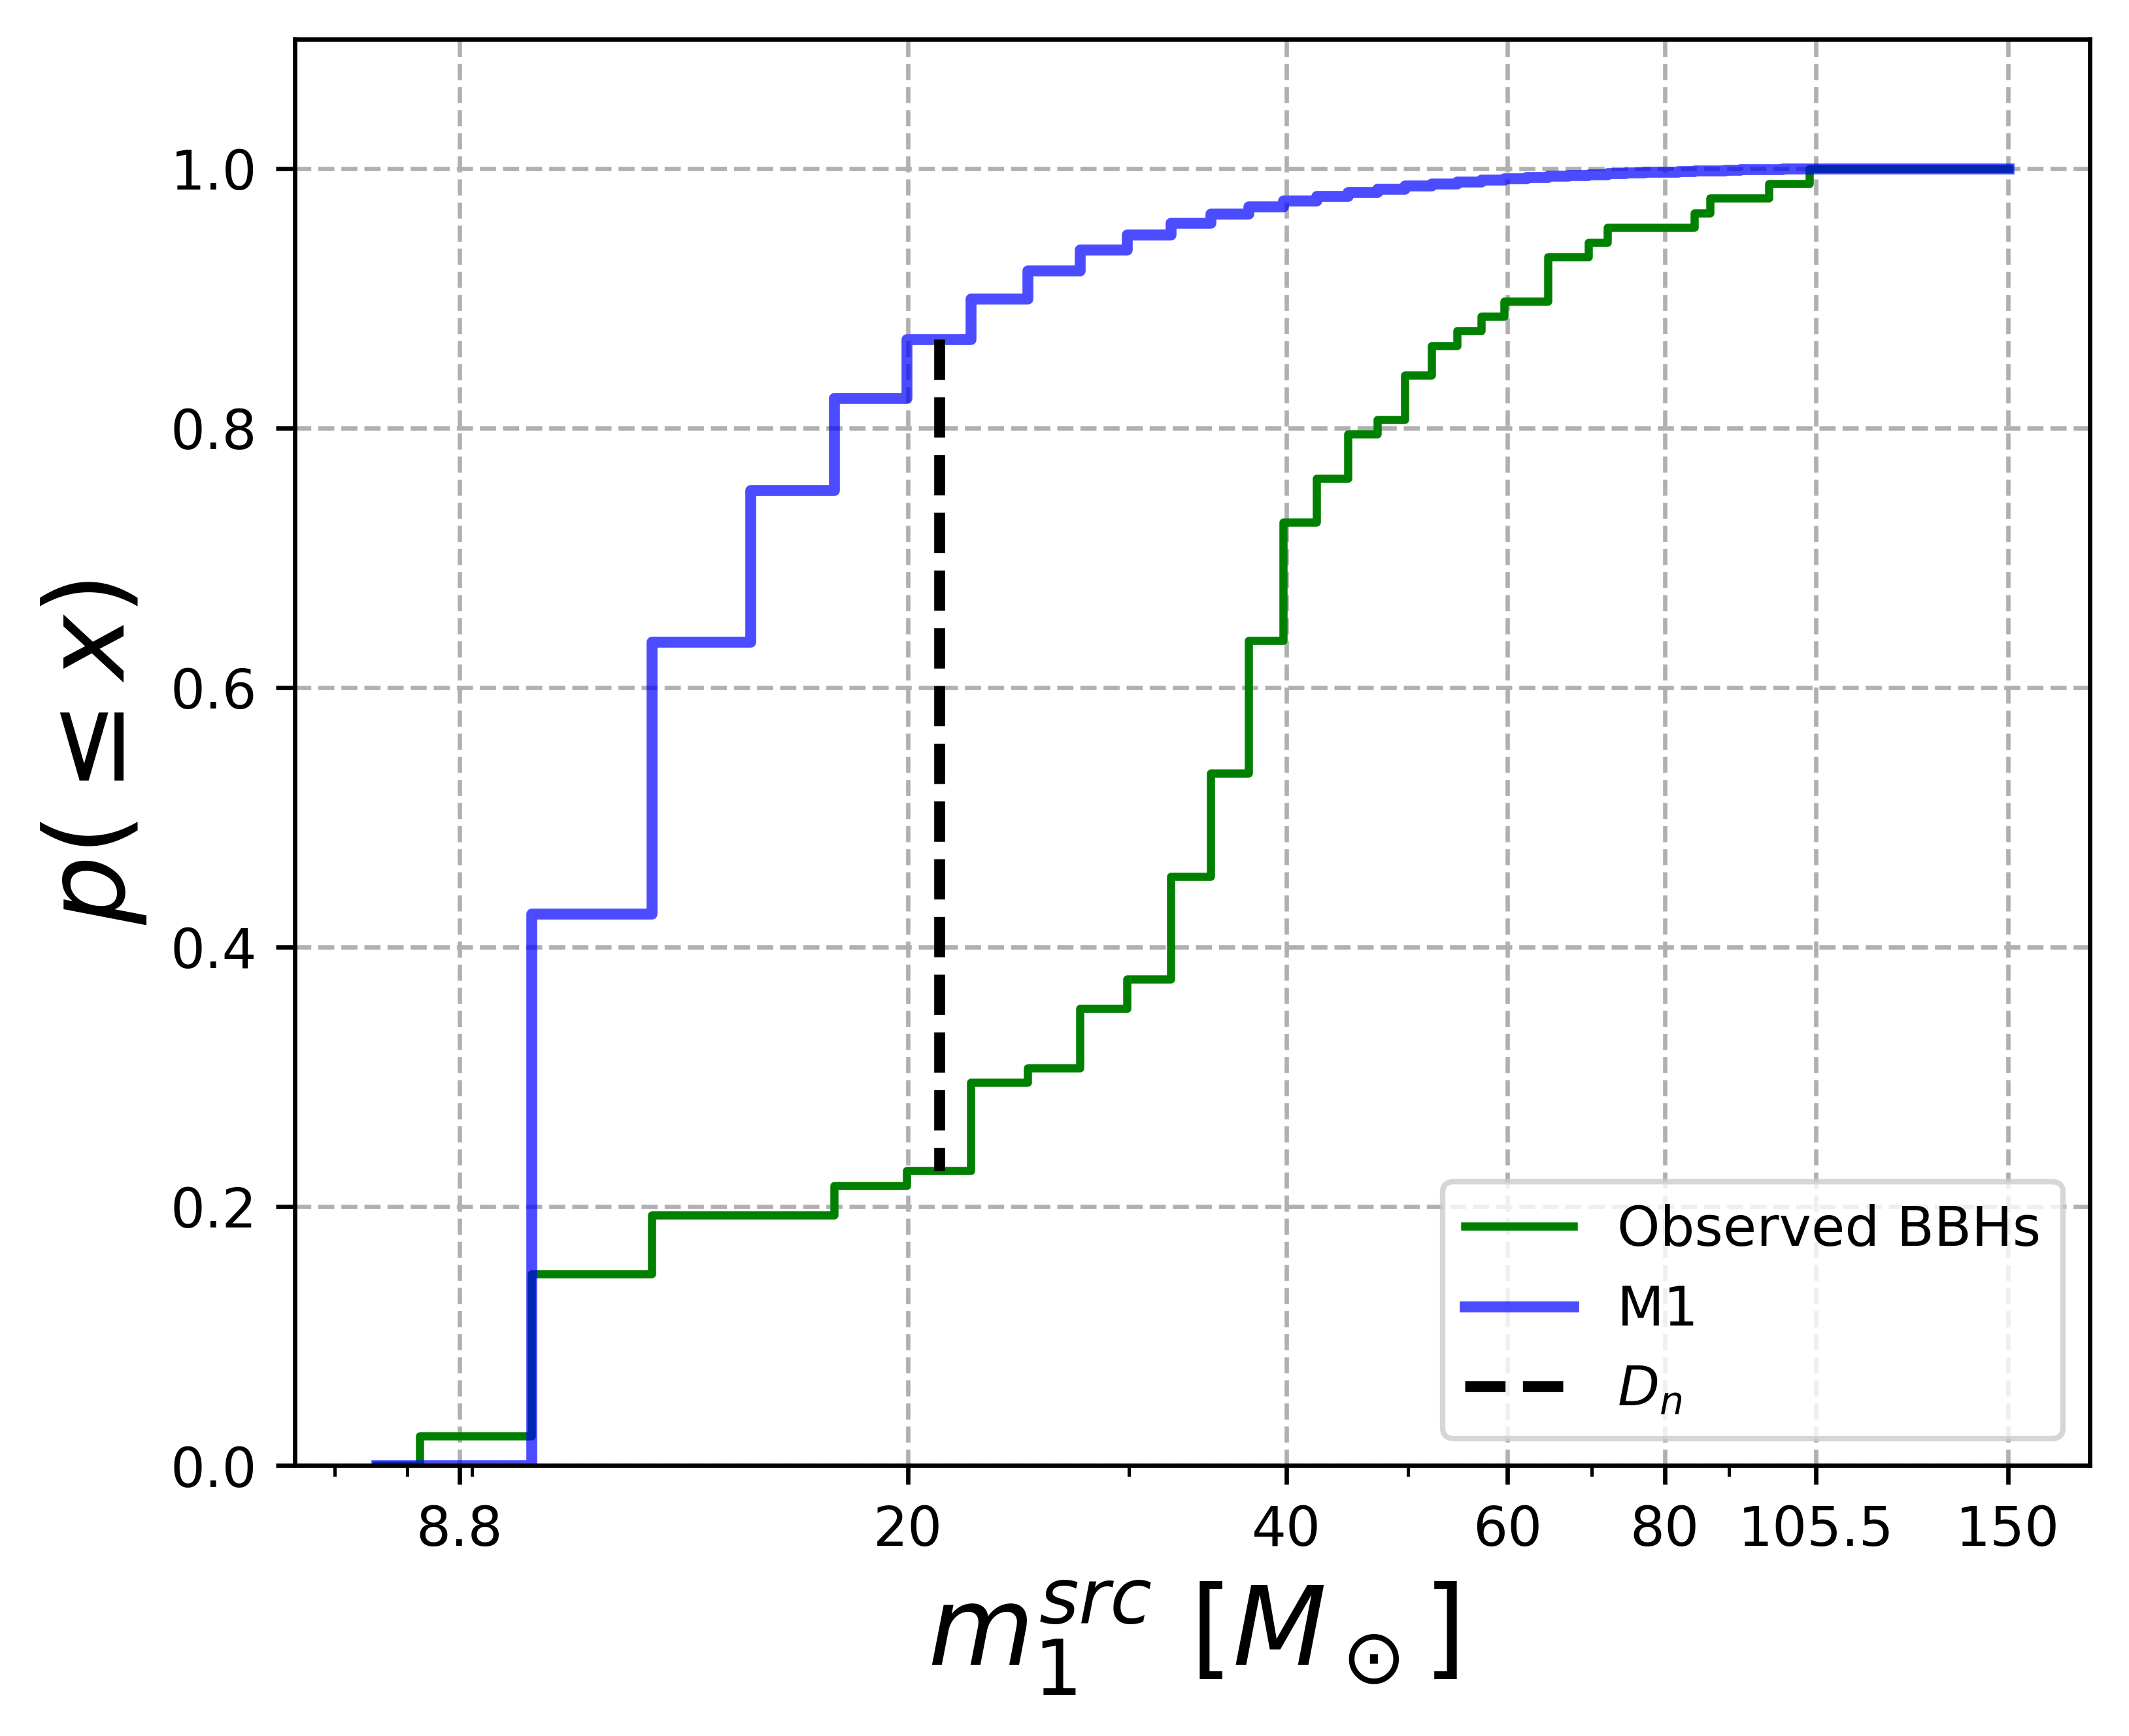

In [3]:
GWTC_BBH = pd.read_csv("/Users/isumi/Desktop/[이수미 학위논문]/code file/file/GWTC_BBH.txt", sep='\s+', encoding='utf-8')
BBH_m1 = GWTC_BBH['m1_median'].round(1)  # 소숫점 첫째자리까지
binwidth=(max(BBH_m1)-min(BBH_m1))/39
test=KStest(data=BBH_m1,x_max=150,m_min=8.8,m_max=105.5,data_binwidth=binwidth,model_binwidth=binwidth,alpha=3.5)
test._test_result()
plt.figure(figsize=(15/2.54,12/2.54),dpi=600)
test._cdf_plot(model_color='blue',model_linestyle='-',model_label="M1")
plt.legend(loc='lower right',bbox_to_anchor=(1,0),ncol=1)
plt.grid(True,linestyle='--')
plt.xscale('log')
#plt.xlim(0,150)
plt.ylim(0,1.1)
plt.xticks([8.8,20,40,60,80,105.5,150],[8.8,20,40,60,80,105.5,150])
test.ks_df